In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# Load the CSV file
district_rainfall_df = pd.read_csv('district_wise_rainfall_normal.csv')

# Save as Parquet file
district_rainfall_df.to_parquet('district_wise_rainfall_normal.parquet')

In [3]:

# Load the CSV files (using relative paths)
crop_recommendation_df1 = pd.read_csv('Crop_recommendation.csv')
crop_recommendation_df2 = pd.read_csv('Crop_recommendation_1.csv')

# Combine the datasets, removing duplicates
combined_crop_recommendation_df = pd.concat([crop_recommendation_df1, crop_recommendation_df2]).drop_duplicates().reset_index(drop=True)

# Save the combined dataset as a Parquet file
combined_crop_recommendation_df.to_parquet('Combined_Crop_recommendation.parquet')

print(f"Combined dataset shape: {combined_crop_recommendation_df.shape}")
print(f"Columns: {combined_crop_recommendation_df.columns.tolist()}")

Combined dataset shape: (3131, 8)
Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']


In [4]:


# Load the combined dataset
combined_crop_recommendation_df = pd.read_parquet('Combined_Crop_recommendation.parquet')

# Define features and target
X = combined_crop_recommendation_df.drop(columns=['label'])
y = combined_crop_recommendation_df['label']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Train and evaluate models
model_accuracies = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred, zero_division=0))

# Select the best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = models[best_model_name]

# Save the best model
joblib.dump(best_model, 'crop_recommendation_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save model accuracies
model_accuracies_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])
model_accuracies_df.to_csv('model_accuracies.csv', index=False)

# Display model accuracies
print("\nModel Accuracies:")
print(model_accuracies_df)

Decision Tree Accuracy: 0.682615629984051
              precision    recall  f1-score   support

           0       0.25      0.26      0.25        27
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        34
           3       0.11      0.09      0.10        22
           4       1.00      1.00      1.00        16
           5       0.05      0.05      0.05        22
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        26
           8       1.00      1.00      1.00        25
           9       0.10      0.11      0.10        19
          10       1.00      1.00      1.00        33
          11       0.21      0.32      0.25        22
          12       0.79      0.88      0.83        17
          13       0.09      0.11      0.10        19
          14       1.00      0.95      0.97        19
          15       1.00      1.00      1.00        35
          16       1.00      1.00      

XGBoost Accuracy: 0.6842105263157895
              precision    recall  f1-score   support

           0       0.16      0.15      0.15        27
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        34
           3       0.14      0.14      0.14        22
           4       1.00      1.00      1.00        16
           5       0.04      0.05      0.04        22
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        26
           8       0.96      1.00      0.98        25
           9       0.05      0.05      0.05        19
          10       1.00      1.00      1.00        33
          11       0.17      0.23      0.20        22
          12       0.94      1.00      0.97        17
          13       0.05      0.05      0.05        19
          14       1.00      0.95      0.97        19
          15       1.00      0.97      0.99        35
          16       1.00      1.00      1.00 

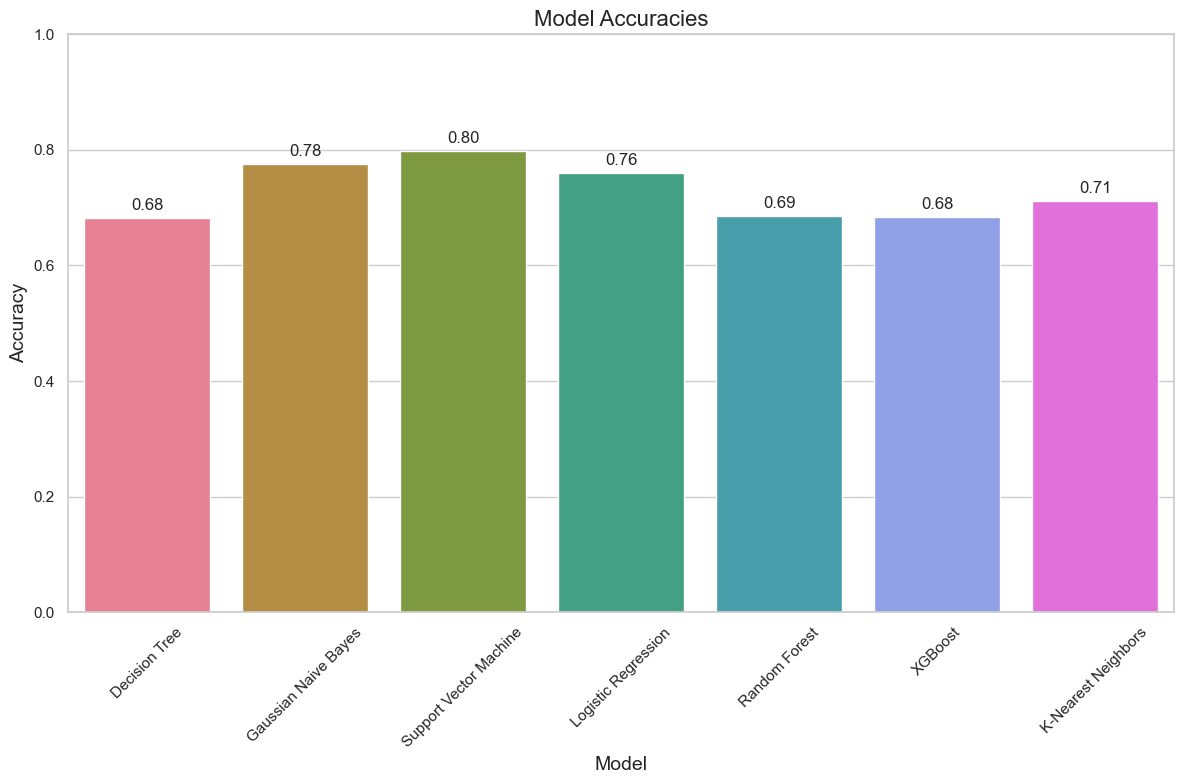

In [5]:
# Load model accuracies
model_accuracies_df = pd.read_csv('model_accuracies.csv')

# Set the style
sns.set(style="whitegrid")

# Create a color palette with different colors for each model
palette = sns.color_palette("husl", len(model_accuracies_df))

# Create the bar plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Model', y='Accuracy', data=model_accuracies_df, palette=palette)

# Add data labels
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Set plot labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracies', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
# Load the dataset
df = pd.read_parquet('Combined_Crop_recommendation.parquet')  # or use CSV if you have it

In [7]:
# Number of rows and columns
print("Shape (rows, columns):", df.shape)

Shape (rows, columns): (3131, 8)


In [8]:
# Column names
print("\nColumns:")
print(df.columns.tolist())


Columns:
['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']


In [9]:
# Data types
print("\nData Types:")
print(df.dtypes)


Data Types:
N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object


In [10]:
# Show first 5 rows
print("\nSample Data:")
print(df.head())


Sample Data:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


In [11]:
# Unique labels in the dataset
unique_labels = df['label'].unique()

print("Unique Labels:")
print(unique_labels)

print("\nTotal Unique Labels:", len(unique_labels))


Unique Labels:
['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee' 'Soyabeans' 'beans' 'peas' 'groundnuts' 'cowpeas']

Total Unique Labels: 27
